# Mounting the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Case_Study_Bengisu_Oniz

/content/drive/My Drive/Case_Study_Bengisu_Oniz


# Ideas & Hypothesis 



## Relation with time of the day, week

Is there any particular relation between the skipping behaviour and time of the day,week?
Maybe listeners are more open to try recommended tracks on Saturdays than Monday or vice verse. Maybe, some listener look for a newness on their first week day.
H0: There is no difference in skipping behavior in different times of the days.
or the skipping behaviour is the same for days of the weeks.

## Relation with track_genre_category

Listeners may be more open to listen recommended tracks from specific track_genre_category.

## Relation with algoritm

Sound Clound has a diverse track database. Amateur users can upload their tracks so it may have more sparse data.

## Relation with the newsness of a track

Maybe listeners are into new tracks than old ones.

## Relation with the user types

# Data Preparation

## Libraries and Reading the 

### Libraries

In [ ]:
import warnings

from google.cloud import bigquery
import pandas_gbq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from scipy import stats
import scipy.stats as ss
#import chart_studio.plotly as py
import json
from matplotlib import mlab
import os
from pandas_profiling import ProfileReport
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from scipy import stats
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import mannwhitneyu # is for independent samples. For related / paired samples, consider

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats


from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from itertools import product
from IPython.display import clear_output
%matplotlib inline

plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



### Functions

In [1]:
def know_your_data(data):
    print('Head: {}'.format(data.ndim))
    print('Shape: {}'.format(data.shape))
    print('Length: {}'.format(data.size))
    print('Columns: {}'.format(data.columns))
    print("-----------------------------------")
    print('Types: {}'.format(data.dtypes))
    print("-----------------------------------")
    print("Nullity Check:\n", pd.isnull(data).any())
    print("Percentage of Null Instances: {}".format(df.isnull().sum() * 100 / len(df)))


def show_hist_plot(df,column_name):
    fig1 = px.histogram(df, x=column_name, color_discrete_sequence=['indianred'], histnorm='percent')
    yaxis=dict(ticksuffix=".00%")

    fig1.update_layout(
       title="Histogram of Number of {}".format(column_name),
        xaxis_title=column_name,
        yaxis_title="Percentage",yaxis=dict(ticksuffix=".00%") )
    fig1.show()

def convert_per_listening_time_to_one(df):
    df['per_listening_time']=df['raw_per_listening_time']
    mask = (df['raw_per_listening_time'] > 1.00) 
    df['per_listening_time'][mask] = 1.00  
    
def create_cum_perc_df(df, column_name):  
    df_counted = df.value_counts([column_name]).rename_axis('unique_values').reset_index(name='counts')
    df_counted['count_running_total'] = df_counted['counts'].cumsum()
    df_counted['percent_of_total'] = df_counted['count_running_total']/df_counted['counts'].sum()*100
    return df_counted  


def have_cum_graph(df,column_name,title, x_label):
    
    df_counted = create_cum_perc_df(df, column_name)
   
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_counted['unique_values'], y=df_counted['percent_of_total'],
                        mode='lines+markers'))
    fig.update_layout(title= title,
                   xaxis_title= x_label,
                   yaxis_title='Percent of the tracks listened')
    fig.show()  
    

def convert_per_listening_time_to_one(df):
    df['per_listening_time']=df['raw_per_listening_time']
    mask = (df['raw_per_listening_time'] > 1.00) 
    df['per_listening_time'][mask] = 1.00
    
def get_part_of_day(df):
    b = [0,4,8,12,16,20,24]
    l = ['Late Night', 'Early Morning','Morning','Noon','Evening','Night']
    df['part_of_day'] = pd.cut(df['hour'], bins=b, labels=l, include_lowest=True)
    
def get_day_month(df): 
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['day_of_week'] = df['date'].dt.day_name()
    df['hour']=df['date'].dt.hour
    
    
def convert_strings_to_datetime(df): 
    df['date'] = pd.to_datetime(df['ts'],unit='s')
    df['track_upload_date'] = pd.to_datetime(df['track_upload_date'],unit='s')
    df['listener_signup_date'] = pd.to_datetime(df['listener_signup_date'],unit='s')

def convert_milliseconds_to_mins(df): 
    df['track_duration_minutes'] = df['track_duration'].div(60000).round(2)
    df['listen_duration_minutes'] = df['listen_duration'].div(60000).round(2)
    df['listener_prev_month_listening_time_minutes'] = df['listener_prev_month_listening_time'].div(60000).round(2)

def stacked_bar_chart_combined_columns(df,grouped_column_1,grouped_column_2,group_column):
    freq_df = df.groupby([grouped_column_1,grouped_column_2])[group_column].value_counts().unstack()
    pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
    return pct_df.plot(kind="bar", stacked=True,figsize=(17,8))

def stacked_bar_chart(df,grouped_column,group_column):
    freq_df = df.groupby([grouped_column])[group_column].value_counts().unstack()
    pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
    return pct_df.plot(kind="bar", stacked=True,figsize=(17,8))


  

def create_violin_plot(df,column_1,column_2):
    fig = go.Figure(data=go.Violin(y=df[column_1], box_visible=True, line_color='black',
                                   meanline_visible=True, fillcolor='lightseagreen', opacity=0.6,
                                   x0='all data'))

    fig.update_layout(yaxis_zeroline=False)

    list_column_2=list(df[column_2].unique())

    for i in list_column_2:
        fig.add_trace(go.Violin(x=df[column_2][df[column_2] == i],
                                y=df[column_1][df[column_2] == i],
                                name=i,
                                box_visible=True,
                                meanline_visible=True))

    fig.show()
    



def get_basic_bar_chart(df,column):
  s_counted=df[column].value_counts()
  df_counted=pd.DataFrame({'labels':s_counted.index, 'count':s_counted.values})
  df_counted['percentage'] = (df_counted['count'] / df_counted['count'].sum()) * 100
  df_counted.plot(kind='bar', x='labels', y='percentage')


def CheckingCorrelations(df,colorstyle):

    column_names=df.columns 
    num = len(column_names)
    correlations = df[column_names].corr()
    print(correlations)

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1,cmap=colorstyle)  
    fig.colorbar(cax)
    ticks = np.arange(0, num, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(column_names)
    ax.set_yticklabels(column_names)
    ax.tick_params(labelsize=13)
    plt.show()
    

    

def cramers_v(df,column_1,column_2):
    
    """ calculate Cramers V statistic for categorial-categorial association.    

        𝑉∈[0.1,0.3]: weak association
        𝑉∈[0.4,0.5]: medium association
        𝑉>0.5: strong association
             
    """
    confusion_matrix = pd.crosstab(df[column_1], df[column_2])
    confusion_matrix=confusion_matrix.values
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v =np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    if cramers_v <= 0.3:
      strength='weak'
    elif cramers_v <= 0.5:
      strength='medium'
    else:          
      strength='strong'
    print(column_1,' & ',column_2, "==> cramers_v score is:", cramers_v)
    print("strength of association is:", strength)
    
def get_relation(df, column_1, column_2):
    do_chi_square_test(df,column_1,column_2)
    print('---------------------------------------------------------------')
    cramers_v(df,column_1, column_2) 

def check_variance_mean_diff_of_per_listening_time(column,value_1,value_2):
    alpha = 0.05

    list_1= list(df[df[column]==value_1]['per_listening_time'])
    list_2= list(df[df[column]==value_2]['per_listening_time'])

    result_levene=stats.levene(list_1, list_2)
    conclusion_levene = "Failed to reject the null hypothesis.(There is no diff in the variances)"
    if result_levene.pvalue > alpha:
        conclusion_levene = "Null Hypothesis (There is no diff in the variances) is rejected."

    result_mannwhitneyu=mannwhitneyu(list_1, list_2) 
    conclusion_mannwhitneyu = "Failed to reject the null hypothesis.(There is no diff in the means)"
    if result_mannwhitneyu.pvalue > alpha:
        conclusion_mannwhitneyu = "Null Hypothesis (There is no diff in the means) is rejected."

    print('Check if ',value_1,' & ',value_2, ' have equal variances')
    print(result_levene)
    print(conclusion_levene)
    print('----------------------------------------')
    print('Check if there is significant difference between the means of ',value_1,' & ',value_2 )
    print(result_mannwhitneyu)
    print(conclusion_mannwhitneyu)

def create_box_violin_plots(df,column):
    fig = go.Figure()

    fig.add_trace(go.Violin(y=df[column], box_visible=True, line_color='black',
                                       meanline_visible=True, fillcolor='gold', opacity=0.6,name=column)
                 )
    fig.add_trace(go.Box(y=df[column],name = column,
                    marker_color = 'darkgoldenrod'))

    fig.show()


def show_hist_plot(df,column_name, color_discrete_sequence='indianred'):
    fig1 = px.histogram(df, x=column_name, color_discrete_sequence=[color_discrete_sequence], histnorm='percent')
    yaxis=dict(ticksuffix="%")

    fig1.update_layout(
       title="Histogram of Number of {}".format(column_name),
        xaxis_title=column_name,
        yaxis_title="Percentage",yaxis=dict(ticksuffix="%") )
    fig1.show()


def remove_outlier_z_score_detection_median(column_name, df):
    df = df.reset_index(drop=True)
    threshold = 3 #this means 3 standard deviations
    var_median = np.median(df[column_name])
    var_sd = np.std(df[column_name])
    z_scores = [(i - var_median)/var_sd for i in df[column_name]]
    indexes = np.where(np.abs(z_scores) > threshold)[0] #array
    dataframe = df.drop(indexes,axis=0) 
    return dataframe

def remove_outlier_z_score_detection_mean(df,column_name):
    df = df.reset_index(drop=True)
    threshold = 3 #this means 3 standard deviations
    var_mean = np.mean(df[column_name])
    var_sd = np.std(df[column_name])
    z_scores = [(i - var_mean)/var_sd for i in df[column_name]]
    indexes = np.where(np.abs(z_scores) > threshold)[0]
    dataframe = df.drop(indexes)
    return dataframe

def create_basic_violin_plot(df,column):

  fig = go.Figure(data=go.Violin(y=df[column], box_visible=True, line_color='black',
                                meanline_visible=True, fillcolor='lightseagreen', opacity=0.6,
                                x0=column))

  fig.update_layout(yaxis_zeroline=False)
  fig.show()

def do_chi_square_test(df,column_1,column_2):


    # create contingency table
    data_crosstab = pd.crosstab(df[column_1],
                                df[column_2],
                                margins=True, margins_name="Total")
    # significance level
    alpha = 0.05

    # Calcualtion of Chisquare test statistics
    chi_square = 0
    rows = df[column_1].unique()
    columns = df[column_2].unique()
    for i in columns:
        for j in rows:
            O = data_crosstab[i][j]
            E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
            chi_square += (O-E)**2/E

    # The p-value approach
    print("The p-value approach to hypothesis testing in the decision rule")
    p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
    conclusion = "Failed to reject the null hypothesis."
    if p_value <= alpha:
        conclusion = "Null Hypothesis (no relation between variables) is rejected."
    #return (p_value,conclusion)
    print(column_1,' & ',column_2, "==> chisquare-score is:", chi_square, " and p value is:", p_value)
    print(conclusion)

### Reading the data

In [ ]:
#path = f'/Users/b.oeniz/Documents/sc_data_science_challenge.json'
#os.chdir('/Users/b.oeniz/Documents')

# Reading the json as a dict
with open('sc_data_science_challenge.json') as json_data:
    data = json.load(json_data)
type(data)


json_obj=json.load(open('sc_data_science_challenge.json'))
df_raw=pd.DataFrame(json_obj['data'],columns=json_obj['columns'])

## Data Manipulation

In [ ]:
#all the data manipulations, please run this chunk to have the final data

df=df_raw.copy()

df = df.astype(dtype={'listener_id': 'string','country_code': 'string'})
df.convert_dtypes()

df.drop_duplicates(inplace=True)
df.duplicated().any()
df = df.drop(df[(df['listen_duration'] < 0)].index)
df.dropna(inplace=True)
df = df.replace('None', np.nan).dropna(how='all')

convert_strings_to_datetime(df)
convert_milliseconds_to_mins(df)
get_day_month(df)
get_part_of_day(df)
df["day_of_week+part_of_day"] = df["day_of_week"].astype(str)  + df["part_of_day"].astype(str) 

df["raw_per_listening_time"] = round(df["listen_duration_minutes"]/df["track_duration_minutes"],2)


#dropping the inf numbers
with pd.option_context('mode.use_inf_as_na', True):
    df = df.dropna(subset=['raw_per_listening_time'], how='all')
pd.set_option('use_inf_as_na', True)

    
convert_per_listening_time_to_one(df)

df = df.drop(df[(df['listen_duration'] < 0)].index)

df = df.drop(df[(df['per_listening_time'] < 0.00)].index)




#list_is_skipped = []
# #use apply function
# for index, row in df.iterrows():
#   if row['track_genre_category'] =='Speech':   
#       if row['listen_duration_minutes'] >5 :
#           list_is_skipped.append('False')
#       elif row['per_listening_time'] > 0.3:
#           list_is_skipped.append('False')
#       else:
#           list_is_skipped.append('True')
#   else:
#       if row['listen_duration_minutes'] > 3 :
#           list_is_skipped.append('False')
#       elif row['per_listening_time'] > 0.3:
#           list_is_skipped.append('False')
#       else:
#           list_is_skipped.append('True')

# df['is_skipped'] = list_is_skipped


def define_skipping(listen_duration_minutes,track_genre_category,per_listening_time):

    if track_genre_category == 'Speech':
        if listen_duration_minutes > 5:
            return False
        elif per_listening_time > 0.3:
            return False
        else:
            return True
    else:
        if listen_duration_minutes > 3:
            return False
        elif per_listening_time > 0.3:
            return False
        else:
            return True

df['is_skipped'] = df.apply(lambda x: define_skipping(x['listen_duration_minutes'],x['track_genre_category'],x['per_listening_time']),axis=1)



perc_type = []

for i in df['per_listening_time']:
    if i <= 0.69:
        perc_type.append('medium')
    elif i <= 0.95:
        perc_type.append('high')
    else:
        perc_type.append('complete')
        
        
df['percentage_type'] = perc_type
        

  
list_is_listener_signup_date = []
list_user_type = []

for index, row in df.iterrows():
    if row['date'] == row['listener_signup_date']:
        list_is_listener_signup_date.append('True')
        list_user_type.append('new user')
    else:
        list_is_listener_signup_date.append('False')
        list_user_type.append('returning user')

        
df['is_listener_signup_date'] = list_is_listener_signup_date
df['user_type'] = list_user_type

list_is_track_old = []

for index, row in df.iterrows():
    if abs((row['date'] - row['track_upload_date']).days) > 365 :
        list_is_track_old.append('True')
    else:
        list_is_track_old.append('False')
       

df['is_track_old'] = list_is_track_old

df_with_outlier=df.copy()

df = remove_outlier_z_score_detection_median('listen_duration_minutes', df)
df = remove_outlier_z_score_detection_median('track_duration_minutes', df)



list_is_long_time_user = []

for index, row in df.iterrows():
    if abs((row['date'] - row['listener_signup_date']).days) > 365 :
        list_is_track_old.append('True')
    else:
        list_is_track_old.append('False')
       

df_listener=df[['listener_id','listener_signup_date','listener_top_genre_category_listened', 'listener_prev_month_listening_time_minutes','listener_prev_month_avg_daily_tracks_listened']]
df_listener.drop_duplicates(inplace=True)


df_without_visitors = df.groupby('listener_id').filter(lambda x: len(x) > 1)  

In [ ]:
df[['listener_id','date','track_id','per_listening_time']].sort_values(['listener_id', 'date'], ascending=[True, True]).head(50)

listener_id  ... per_listening_time
0   0001d5755511cae40e5b32d83a3decce  ...               1.00
1   0001d5755511cae40e5b32d83a3decce  ...               0.28
2   0001d5755511cae40e5b32d83a3decce  ...               0.39
3   000264c5b34ad04999535c8b6a8b86e2  ...               1.00
4   000264c5b34ad04999535c8b6a8b86e2  ...               0.43
5   000264c5b34ad04999535c8b6a8b86e2  ...               0.79
6   000264c5b34ad04999535c8b6a8b86e2  ...               1.00
7   000264c5b34ad04999535c8b6a8b86e2  ...               1.00
8   000264c5b34ad04999535c8b6a8b86e2  ...               1.00
9   000264c5b34ad04999535c8b6a8b86e2  ...               1.00
10  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
11  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
12  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
13  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
14  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
15  000264c5b34ad04999535c8b6a8b86e2  ...               0.52
16  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
17  000264c5b34ad04999535c8b6a8b86e2  ...               0.00
18  000264c5b34ad04999535c8b6a8b86e2  ...               0.02
19  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
20  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
21  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
22  000264c5b34ad04999535c8b6a8b86e2  ...               0.59
23  000264c5b34ad04999535c8b6a8b86e2  ...               0.44
24  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
25  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
26  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
27  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
28  000264c5b34ad04999535c8b6a8b86e2  ...               0.22
29  000264c5b34ad04999535c8b6a8b86e2  ...               0.12
30  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
31  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
32  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
33  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
34  000264c5b34ad04999535c8b6a8b86e2  ...               0.51
35  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
36  000264c5b34ad04999535c8b6a8b86e2  ...               0.02
37  000264c5b34ad04999535c8b6a8b86e2  ...               0.20
38  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
39  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
40  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
41  000264c5b34ad04999535c8b6a8b86e2  ...               0.96
42  000264c5b34ad04999535c8b6a8b86e2  ...               0.03
43  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
44  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
45  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
46  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
47  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
48  000264c5b34ad04999535c8b6a8b86e2  ...               1.00
49  000264c5b34ad04999535c8b6a8b86e2  ...               1.00

[50 rows x 4 columns]



> If these were all the tracks that listeners listeneded, we needed to add another condition. If a track is the last track of a session (30 min or 1 hour) than we wouldn't consider any last song of the session as skipped cause users might stop using the platform at that time.



# About Data

In [ ]:
df_raw.sample(2)

ts  ... listener_prev_month_avg_daily_tracks_listened
824817  1468131943  ...                                           NaN
279915  1468007074  ...                                          69.0

[2 rows x 15 columns]

In [ ]:
df.sample()

ts country_code  ...       user_type is_track_old
298843  1467320967           GB  ...  returning user         True

[1 rows x 32 columns]

In [ ]:
round(df_raw.describe())

ts  ...  listener_prev_month_avg_daily_tracks_listened
count  8.281690e+05  ...                                       766561.0
mean   1.468263e+09  ...                                           46.0
std    7.637010e+05  ...                                           43.0
min    1.466902e+09  ...                                            2.0
25%    1.467601e+09  ...                                           16.0
50%    1.468253e+09  ...                                           33.0
75%    1.468925e+09  ...                                           62.0
max    1.469580e+09  ...                                          638.0

[8 rows x 7 columns]

In [ ]:
df_listener.head()

# Feature Creations

### Outlier detection

In [ ]:
show_hist_plot(df_with_outlier,'listen_duration_minutes','green') 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_hist_plot(df_with_outlier,'track_duration_minutes','purple')

Output hidden; open in https://colab.research.google.com to view.

Since the data is not normally distrubuted, is right skewed, it is better to remove outliers with median instead of mean. Let's test both them

listen_duration_minutes

In [ ]:
df_z_score_detection_median_listen_duration_minutes=remove_outlier_z_score_detection_median('listen_duration_minutes', df_with_outlier)

round(df_z_score_detection_median_listen_duration_minutes.describe())

ts  track_duration  ...  raw_per_listening_time  per_listening_time
count  7.511800e+05        751180.0  ...                751180.0            751180.0
mean   1.468242e+09        476093.0  ...                     1.0                 1.0
std    7.626750e+05        829796.0  ...                     0.0                 0.0
min    1.466902e+09           317.0  ...                     0.0                 0.0
25%    1.467584e+09        301740.0  ...                     0.0                 0.0
50%    1.468211e+09        373473.0  ...                     1.0                 1.0
75%    1.468897e+09        449321.0  ...                     1.0                 1.0
max    1.469580e+09      42004074.0  ...                    79.0                 1.0

[8 rows x 13 columns]

In [ ]:
show_hist_plot(df_z_score_detection_median_listen_duration_minutes,'listen_duration_minutes','green')

Output hidden; open in https://colab.research.google.com to view.

track_duration_minutes

In [ ]:
df_z_score_detection_median_track_duration_minutes=remove_outlier_z_score_detection_median('track_duration_minutes', df_z_score_detection_median_listen_duration_minutes)
round(df_z_score_detection_median_track_duration_minutes.describe())

ts  track_duration  ...  raw_per_listening_time  per_listening_time
count  7.409980e+05        740998.0  ...                740998.0            740998.0
mean   1.468242e+09        395458.0  ...                     1.0                 1.0
std    7.626460e+05        225554.0  ...                     0.0                 0.0
min    1.466902e+09           317.0  ...                     0.0                 0.0
25%    1.467584e+09        300416.0  ...                     0.0                 0.0
50%    1.468212e+09        371646.0  ...                     1.0                 1.0
75%    1.468897e+09        445112.0  ...                     1.0                 1.0
max    1.469580e+09       2861752.0  ...                    79.0                 1.0

[8 rows x 13 columns]

In [ ]:
show_hist_plot(df_z_score_detection_median_track_duration_minutes,'track_duration_minutes','purple')

Output hidden; open in https://colab.research.google.com to view.

### Determining Skipping Behaviors 

**Track Durations & Listening Times**

In [ ]:
df['listen_duration_minutes'].describe()

count    740998.000000
mean          4.281818
std           3.515749
min           0.000000
25%           0.710000
50%           4.660000
75%           6.540000
max          31.050000
Name: listen_duration_minutes, dtype: float64

In [ ]:
fig = px.box(df, y="listen_duration_minutes")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

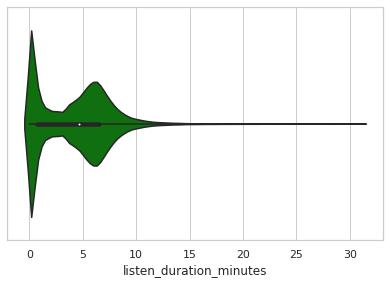

In [ ]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=df["listen_duration_minutes"],color="green")
plt.show()

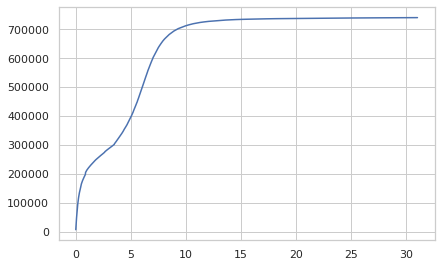

In [ ]:
df['listen_duration_minutes'].value_counts().sort_index().cumsum().plot()

> Tracks listened more than 3 mins are assumed not skipped


**Percentage of the Listining**

In [ ]:
f = go.Figure()

f.add_trace(go.Violin(y=df['per_listening_time'], box_visible=True, line_color='black',
                                   meanline_visible=True, fillcolor='gold', opacity=0.6,name='per_listening_time')
             )
f.add_trace(go.Box(y=df['per_listening_time'],name = 'per_listening_time',
                marker_color = 'darkgoldenrod'))

f.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_less_1=df[df['per_listening_time']<1]

fig1 = px.histogram(df_less_1, x='per_listening_time', color='track_genre_category', histnorm='percent')
yaxis=dict(ticksuffix=".00%")

fig1.update_layout(
    title="Histogram of Number of {}".format('per_listening_time'),
    xaxis_title='per_listening_time',
    yaxis_title="Percentage",yaxis=dict(ticksuffix=".00%") )
fig1.show()

In [ ]:
df['per_listening_time'].describe()

count    813503.000000
mean          0.671333
std           0.426586
min           0.000000
25%           0.140000
50%           1.000000
75%           1.000000
max           1.000000
Name: per_listening_time, dtype: float64

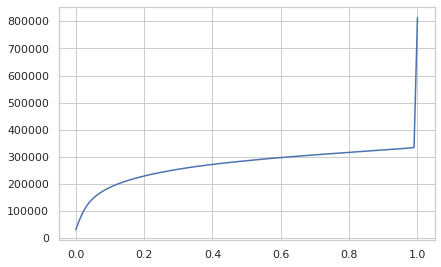

In [ ]:
df['per_listening_time'].value_counts().sort_index().cumsum().plot()

In [ ]:
grouped = df.groupby("track_genre_category")
round(grouped["track_duration_minutes"].describe(),2)

count  mean    std   min   25%   50%    75%    max
track_genre_category                                                       
Classical               2497.0  7.66   4.82  0.76  4.86  6.68   9.07  45.60
Country                 1005.0  6.16   2.47  0.32  5.31  5.95   6.75  33.20
Dance & Electronic    215782.0  7.32   3.72  0.01  5.55  6.70   8.21  47.70
HipHop & R&B          397799.0  6.09   3.77  0.01  4.64  5.85   6.95  47.66
Jazz                    1537.0  7.29   3.93  0.46  5.01  6.35   8.77  46.12
Latin                   2375.0  7.98   5.77  0.92  5.62  6.42   7.60  45.83
Metal                   1330.0  7.07   3.35  0.10  5.20  6.73   8.42  35.04
Pop                    53696.0  6.60   2.59  0.07  5.36  6.38   7.45  47.10
Reggae                  5017.0  7.18   4.78  0.28  5.26  6.21   7.32  47.61
Rock                   33595.0  6.66   2.64  0.28  5.31  6.38   7.48  47.25
Speech                  2754.0  9.72  10.21  0.05  4.05  6.00  10.22  47.32
Unknown                  800.0  6.29   3.58  0.32  5.07  5.78   7.17  46.26
World                  22811.0  7.56   3.94  0.17  5.60  6.86   8.42  47.62

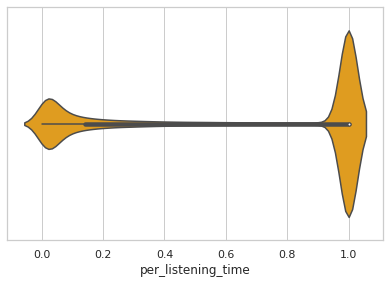

In [ ]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=df["per_listening_time"],color="orange")
plt.show()

In [ ]:
show_hist_plot(df,'per_listening_time','gold')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
show_hist_plot(df,'per_listening_time','#B68100')

Output hidden; open in https://colab.research.google.com to view.

**Listening percentage < 1**

In [ ]:
show_hist_plot(df[df['per_listening_time']<1],'per_listening_time','#B68100')

In [ ]:
df_less_1=df[df['per_listening_time']<1]

fig_less = go.Figure()

fig_less.add_trace(go.Violin(y=df_less_1['per_listening_time'], box_visible=True, line_color='black',
                                   meanline_visible=True, fillcolor='#B68100', opacity=0.6,name='per_listening_time')
             )
fig_less.add_trace(go.Box(y=df_less_1['per_listening_time'],name = 'per_listening_time B',
                marker_color = '#B68100'))

fig_less.show()

Output hidden; open in https://colab.research.google.com to view.

Since we have longer tracks in Speech category, it is better to use different thresehold for skipping behavior. Therefore, instead of using 3 mins listen duration thereshold, we use 5 mins thereshold.

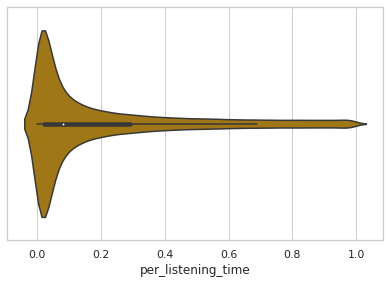

In [ ]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=df_less_1["per_listening_time"],color="#B68100")
plt.show()

If less than 30% of a track is listened, then we assume it is skipped

**Level of Listening**

 If a tracks is listened 
 
    30%- 69% ===> medium 

    69% -95% ===> high

    95% -100%  ===> complete 

# Details of Data

In [ ]:
df.sample(5).T

512951  ...                            440867
ts                                                                   1467593310  ...                        1466928689
country_code                                                                 US  ...                                US
client_version                                                          204.0.4  ...                           208.0.0
listening_context                                                        tracks  ...                            tracks
recommender_algorithm_name                                        content-based  ...                     content-based
track_id                                       11cac4e6b859d12c4bd4313db80983f4  ...  c37e9b416ca0d7a3921118f77f7ad46d
track_genre_category                                         Dance & Electronic  ...                      HipHop & R&B
track_upload_date                                           2016-06-01 00:00:00  ...               2015-03-25 00:00:00
track_duration                                                           319433  ...                            378640
listen_duration                                                          312960  ...                                 0
listener_id                                    aea1d568156b1fa911bfe1f1e39d4baa  ...  95251dd63ffadba93d2d1c7ff9af0cb9
listener_signup_date                                        2011-08-02 00:00:00  ...               2013-01-15 00:00:00
listener_top_genre_category_listened                         Dance & Electronic  ...                      HipHop & R&B
listener_prev_month_listening_time                                  4.11581e+09  ...                       7.85235e+08
listener_prev_month_avg_daily_tracks_listened                                24  ...                                12
date                                                        2016-07-04 00:48:30  ...               2016-06-26 08:11:29
track_duration_minutes                                                     5.32  ...                              6.31
listen_duration_minutes                                                    5.22  ...                                 0
listener_prev_month_listening_time_minutes                              68596.8  ...                           13087.2
month                                                                         7  ...                                 6
day                                                                           4  ...                                26
day_of_week                                                              Monday  ...                            Sunday
hour                                                                          0  ...                                 8
part_of_day                                                          Late Night  ...                     Early Morning
day_of_week+part_of_day                                        MondayLate Night  ...               SundayEarly Morning
raw_per_listening_time                                                     0.98  ...                                 0
per_listening_time                                                         0.98  ...                                 0
is_skipped                                                                False  ...                              True
percentage_type                                                        complete  ...                            medium
is_listener_signup_date                                                   False  ...                             False
user_type                                                        returning user  ...                    returning user
is_track_old                                                              False  ...                              True

[32 rows x 5 columns]

In [ ]:
know_your_data(df)

Head: 2
Shape: (740998, 32)
Length: 23711936
Columns: Index(['ts', 'country_code', 'client_version', 'listening_context',
       'recommender_algorithm_name', 'track_id', 'track_genre_category',
       'track_upload_date', 'track_duration', 'listen_duration', 'listener_id',
       'listener_signup_date', 'listener_top_genre_category_listened',
       'listener_prev_month_listening_time',
       'listener_prev_month_avg_daily_tracks_listened', 'date',
       'track_duration_minutes', 'listen_duration_minutes',
       'listener_prev_month_listening_time_minutes', 'month', 'day',
       'day_of_week', 'hour', 'part_of_day', 'day_of_week+part_of_day',
       'raw_per_listening_time', 'per_listening_time', 'is_skipped',
       'percentage_type', 'is_listener_signup_date', 'user_type',
       'is_track_old'],
      dtype='object')
-----------------------------------
Types: ts                                                        int64
country_code                                            

In [ ]:
total_unique_listener_id=df['listener_id'].nunique()
total_unique_listener_id

47927

In [ ]:
total_unique_track_id=df['track_id'].nunique()
total_unique_track_id

345803

We have 740.998 instances with 15 features in the dataset. We have 47.927 unique listeners and 384.470 tracks

The description of the columns are: 

● **ts**: the time the user listened to the recommended track (as Unix timestamp)

● **country_code**: the two-character country abbreviation where the user was located at the
time of listening

● **client_version**: the version of the client that the listener was using

● **listening_context**: the section of the SoundCloud web app where the user listened to the
recommended track

    ○ “collection”: any of the pages in the Collection section
    ○ “you”: the listener’s own profile page
    ○ “search”: any of the pages in the Search experience
    ○ “stream”: the page of the Stream experience
    ○ “personal-recommended’: the page of the Discover experience for personalized
    recommendations
    ○ “charts”: the page of the Charts experience for trending content discovery
    ○ “tracks”: the dedicated page of an uploaded track
    ○ “users”: the profile page of another user (not the one listening)
    ○ “playlists”: the dedicated page of a playlist
    
● **recommender_algorithm_name**: the name of the algorithm that produced the track recommendation for the listener

    ○ “content-based”: an implementation of content-based filtering
    ○ “collaborative”: an implementation of collaborative filtering
    ○ “hybrid”: a hybrid implementation of content-based and collaborative filtering
    ○ “fallback”: a static list of the popular tracks, used only as a fallback strategy
    
● **track_id**: the unique identifier of the recommended track

● **track_genre_category**: the broad genre category describing the recommended track

● **track_upload_date**: the date the recommended track was uploaded (as Unix timestamp)

● **track_duration**: the length of the recommended track recording (in milliseconds)

● **listen_duration**: the duration that the user listened to the recommended track (in
milliseconds)

● **listener_id**: the unique identifier of the user who listened to the recommended track

● **listener_signup_date**: the date the listener created their SoundCloud account (as Unix
timestamp)

● **listener_top_genre_category_listened**: the genre category that the user has most
frequently listened to (based on all their past listening in all contexts)
       
● **listener_prev_month_listening_time**: the total duration that the user listened in the previous month (in all contexts)

● **listener_prev_month_avg_daily_tracks_listened**: the daily mean number of distinct tracks that the user listened in the previous month (in all contexts)

There are missing variables in *listener_top_genre_category_listened*, *listener_prev_month_listening_time* & *listener_prev_month_avg_daily_tracks_listened*.It is good that only 7.4 % of listener_prev_month_listening_time &
listener_prev_month_avg_daily_tracks_listened columns has null values.

In [ ]:
print("Decribing the data columns")
round(df.describe())

Decribing the data columns


ts  track_duration  ...  raw_per_listening_time  per_listening_time
count  8.225760e+05        822576.0  ...                822576.0            822576.0
mean   1.468256e+09        525241.0  ...                     1.0                 1.0
std    7.606740e+05        994790.0  ...                     1.0                 0.0
min    1.466902e+09           317.0  ...                     0.0                 0.0
25%    1.467597e+09        303158.0  ...                     0.0                 0.0
50%    1.468243e+09        375027.0  ...                     1.0                 1.0
75%    1.468907e+09        453985.0  ...                     1.0                 1.0
max    1.469580e+09      42004074.0  ...                   349.0                 1.0

[8 rows x 13 columns]

Avg 42% of the recommended tracks are listened

## Quick check from Pandas Profiling Report

In [ ]:
prof = ProfileReport(df)
#prof.to_file(output_file='output.html')
prof

In [ ]:
prof_df_listener = ProfileReport(df_listener)
prof_df_listener.to_file(output_file='output_prof_df_listener.html')
prof_df_listener

#### Findings from Pandas Profiling Report 📝🔦
➾ A categorical feature is said to possess high cardinality when there are too many of these unique values.

**➠date**

Date of the data is between 2016-06-26 and 2016-07-27

Most of the tracks are listened at late evening.

**➠country_code**

The dataset is from US 🇺🇸 & GB 🇬🇧 

**➠client_version**

There are 236 distinct values in client version which means there is a high cardinality.

**➠listening_context**

    ➟Most of the users listens recommended tracks from tracks(%⁉️) and the profile page of another users (%⁉️)



**➠recommender_algorithm_name**

The most of recommendated tracks procuded from content-based algorithm (%⁉️)


**➠track_genre_category**
track_genre_category is highly correlated with listener_top_genre_category_listened. It seems SC mostly recommend songs from the same genre.


**➠listener_top_genre_category** is HipHop & R&B


**➠track_upload_date & listener_signup_date**

track_upload_date & listener_signup_date increase for the latest dates

tracki listening time is correlated with listeber_prev_mombt listening time

**Correlations from pandas profiling**

● is_listener_signup_date is highly correlated with recommender_algorithm_name and 10 other fields	

● listening_context is highly correlated with is_listener_signup_date

● is_skipped is highly correlated with is_listener_signup_date and 2 other fields

● is_new_user is highly correlated with recommender_algorithm_name 

● track_genre_category is highly correlated with is_listener_signup_date

● percentage_type is highly correlated with is_listener_signup_date 

● listener_top_genre_category_listened is highly correlated with is_listener_signup_date 

● part_of_day is highly correlated with is_listener_signup_date 

## Correlations

### Numeric Features

In [ ]:
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64', 'int64'])

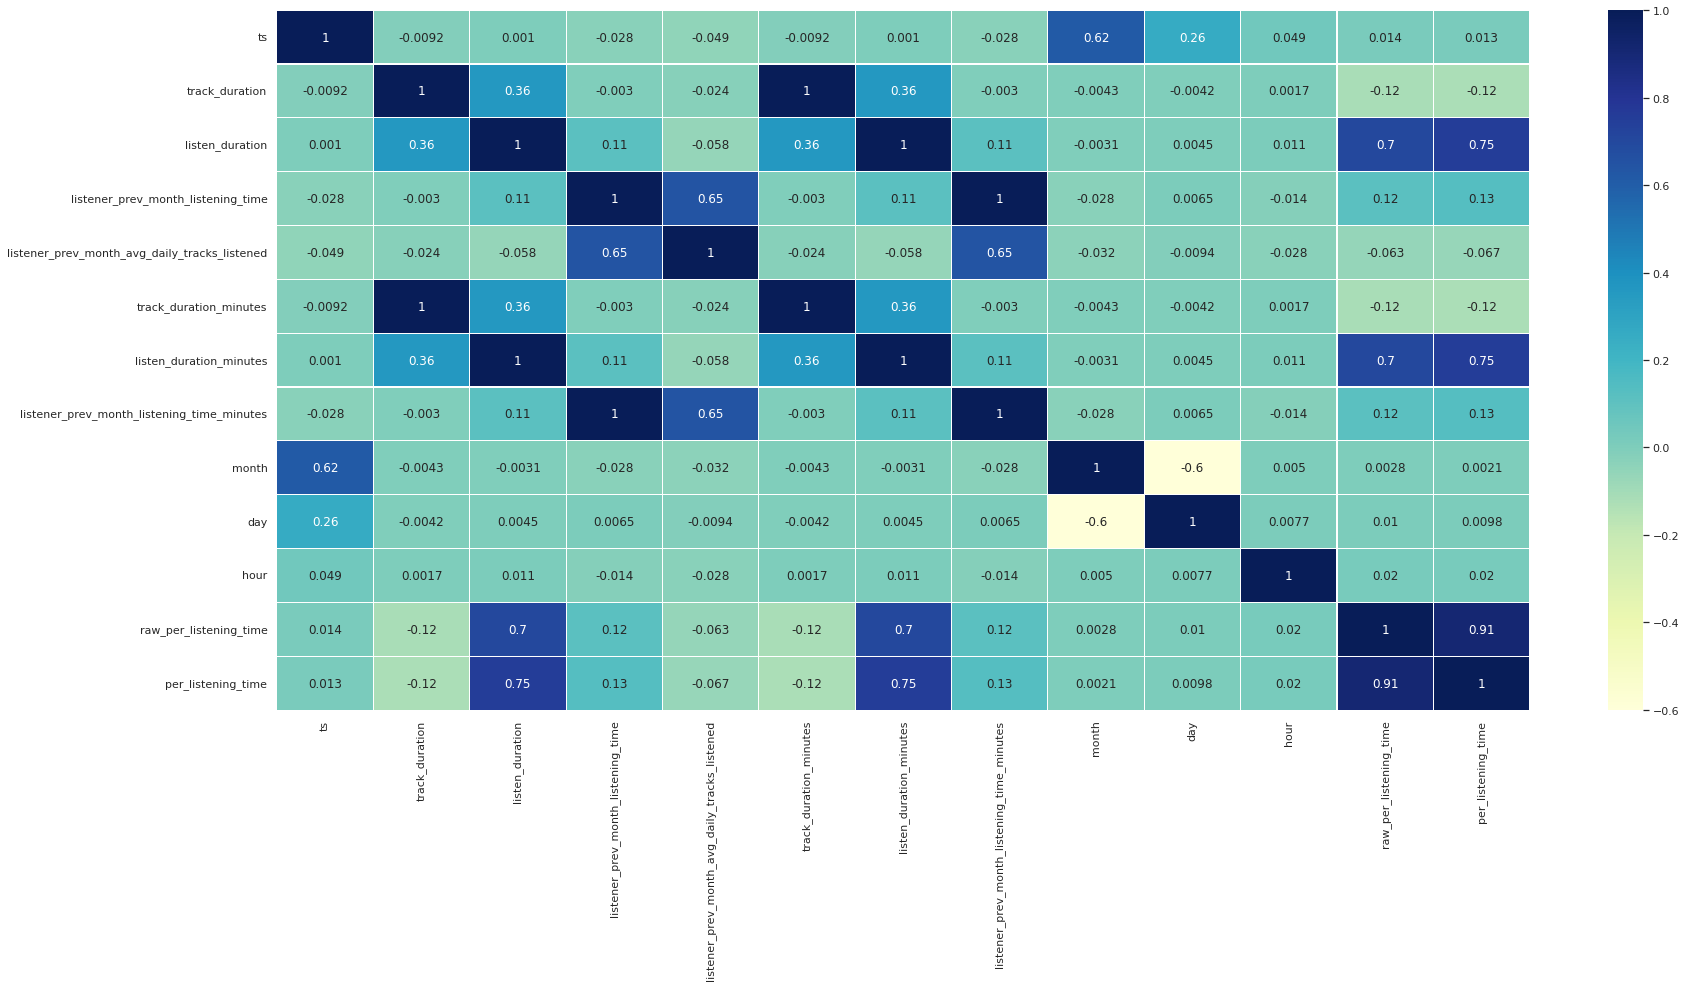

In [ ]:
plt.figure(figsize=(25,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);



> There is a no strong relation within the features



Referances


https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#r31b0b1c0fec3-4